# Rendering MultibodyPlant Tutorial

For instructions on how to run these tutorial notebooks, please see
the [README](https://github.com/RobotLocomotion/drake/blob/master/tutorials/README.md).

This shows examples of:
* Adding a `MultibodyPlant` and `SceneGraph` to a diagram
* Adding two separate IIWAs to the `MultibodyPlant`
* Adding LCM visualization for Drake Visualizer
* Adding `meshcat` visualization
* Adding a camera with a VTK renderer
* Rendering color and label images (at zero configuration)
* Using `SceneGraphInspector` to query `SceneGraph` geometries
* Associating `SceneGraph` geometries with `MultibodyPlant` bodies
* Extracting `RenderLabel`s from given geometries
* Remapping labels to only distinguish by `ModelInstanceIndex`.

## Necessary Imports

In [9]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [10]:
from pydrake.common import FindResourceOrThrow
from pydrake.geometry import ConnectDrakeVisualizer
from pydrake.geometry.render import (
    DepthCameraProperties,
    RenderLabel,
    MakeRenderEngineVtk,
    RenderEngineVtkParams,
)
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.multibody.tree import BodyIndex
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.meshcat_visualizer import MeshcatVisualizer
from pydrake.systems.sensors import RgbdSensor

## Define helper methods

In [11]:
def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)

In [12]:
reserved_labels = [
    RenderLabel.kDoNotRender,
    RenderLabel.kDontCare,
    RenderLabel.kEmpty,
    RenderLabel.kUnspecified,
]

def colorize_labels(image):
    """Colorizes labels."""
    # TODO(eric.cousineau): Revive and use Kuni's palette.
    cc = mpl.colors.ColorConverter()
    color_cycle = plt.rcParams["axes.prop_cycle"]
    colors = np.array([cc.to_rgb(c["color"]) for c in color_cycle])
    bg_color = [0, 0, 0]
    image = np.squeeze(image)
    background = np.zeros(image.shape[:2], dtype=bool)
    for label in reserved_labels:
        background |= image == int(label)
    color_image = colors[image % len(colors)]
    color_image[background] = bg_color
    return color_image

## Create diagram builder with plant and scene graph.

In [13]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)

## Add first IIWA at origin.

In [14]:
parser = Parser(plant)
iiwa_file = FindResourceOrThrow(
   "drake/manipulation/models/iiwa_description/sdf/"
   "iiwa14_no_collision.sdf")

In [15]:
iiwa_1 = parser.AddModelFromFile(iiwa_file, model_name="iiwa_1")
plant.WeldFrames(
    plant.world_frame(), plant.GetFrameByName("iiwa_link_0", iiwa_1),
    X_AB=xyz_rpy_deg([0, 0, 0], [0, 0, 0]))

<WeldJoint_[float] name='WorldBody_welds_to_iiwa_link_0' index=7 model_instance=2>

## Add second IIWA at next to first.

In [16]:
iiwa_2 = parser.AddModelFromFile(iiwa_file, model_name="iiwa_2")
plant.WeldFrames(
    plant.world_frame(), plant.GetFrameByName("iiwa_link_0", iiwa_2),
    X_AB=xyz_rpy_deg([0, 1, 0], [0, 0, 0]))

<WeldJoint_[float] name='WorldBody_welds_to_iiwa_link_0' index=15 model_instance=3>

## Add renderer.

In [17]:
renderer_name = "renderer"
scene_graph.AddRenderer(
    renderer_name, MakeRenderEngineVtk(RenderEngineVtkParams()))

## Add camera with same color and depth properties.

In [18]:
# N.B. These properties are chosen arbitrarily.
depth_prop = DepthCameraProperties(
    width=640, height=480, fov_y=np.pi/4,
    renderer_name=renderer_name,
    z_near=0.01, z_far=10.)

world_id = plant.GetBodyFrameIdOrThrow(plant.world_body().index())
X_WB = xyz_rpy_deg([4, 0, 0], [-90, 0, 90])
sensor = RgbdSensor(
    world_id, X_PB=X_WB,
    color_properties=depth_prop, depth_properties=depth_prop)
builder.AddSystem(sensor)
builder.Connect(
    scene_graph.get_query_output_port(),
    sensor.query_object_input_port())

## Add Drake Visualizer.

You will need to have launched the `drake_visualizer` binary
before calling `simulator.Initialize(...)`.

In [19]:
ConnectDrakeVisualizer(builder, scene_graph)

## Add and show `meshcat` Visualizer.

This will show a `meshcat` widget inside of this notebook.

**Note**: This currently does *not* work in a remote workflow (e.g.
Docker without appropriate port forwarding, Binder, Google Colab, etc.).
Please see [#12645](https://github.com/RobotLocomotion/drake/issues/12645)
for more details. If this does appear to work, then it is most likely due
to you running a local instance of the `meshcat` server.

<!-- TODO(eric.cousineau): Move this to a separate visualization-specific
tutorial. -->

In [20]:
meshcat_vis = builder.AddSystem(
    MeshcatVisualizer(scene_graph, zmq_url="new", open_browser=False))
builder.Connect(
    scene_graph.get_pose_bundle_output_port(),
    meshcat_vis.get_input_port(0))
meshcat_vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


## Finalize plant and build diagram.

In [21]:
plant.Finalize()
diagram = builder.Build()

## Create context and get subsystem contexts.

In [22]:
diagram_context = diagram.CreateDefaultContext()
sensor_context = sensor.GetMyMutableContextFromRoot(diagram_context)
sg_context = scene_graph.GetMyMutableContextFromRoot(diagram_context)

## Publish visualization message with a default context.

In [23]:
Simulator(diagram).Initialize()

## Render color and label images using matplotlib
Note that this uses the default labeling scheme, using `body.index()`.

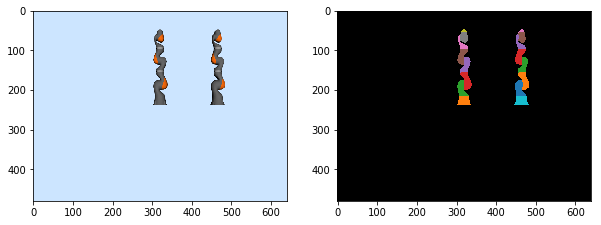

In [24]:
color = sensor.color_image_output_port().Eval(sensor_context).data
label = sensor.label_image_output_port().Eval(sensor_context).data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(color)
ax[1].imshow(colorize_labels(label))

## Change labels to model instance by direct remapping.

We will loop through each geometry item, get it's corresponding body, and then
remap the original label to a label that is only distinct for model instances.

**NOTE**: If the labels in the given plant merge the two model instances together,
then this will not fix that. The correct behavior would be to update the RenderLabel
values in the geometry instances themselves.

*TODO(eric.cousineau)*: Add an example of updating only the RenderLabel.

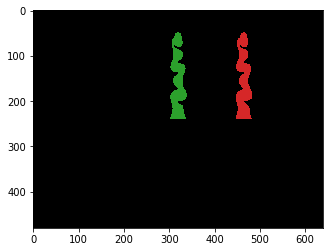

In [25]:
query_object = scene_graph.get_query_output_port().Eval(sg_context)
inspector = query_object.inspector()

label_by_model = label.copy()
for geometry_id in inspector.GetAllGeometryIds():
    body = plant.GetBodyFromFrameId(inspector.GetFrameId(geometry_id))
    geometry_label = inspector.GetPerceptionProperties(
        geometry_id).GetProperty("label", "id")
    # WARNING: If you do not cast the `geometry_label` to `int`, this
    # comparison will take a long time since NumPy will do
    # element-by-element comparison using `RenderLabel.__eq__`.
    mask = (label == int(geometry_label))
    label_by_model[mask] = int(body.model_instance())

plt.imshow(colorize_labels(label_by_model))